# Capstone Project - Vermont Pizza
### Applied Data Science Capstone Final Project by Michael Morin

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

![alt text](https://www.ccn.com/wp-content/uploads/2018/12/vermont-welcome-sign-blockchain.jpg "")
![alt text](https://images.unsplash.com/photo-1534308983496-4fabb1a015ee?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1355&q=80)

---

## INTRODUCTION Business Problem <a name="introduction"></a>
### QUESTION : Is a new pizza restaurant in Vermont a viable business proposition?  If so, where should it be located?

Vermont is a state well known for its green mountains, ski resorts, colorful foliage, and landscapes.  It's also famous for its cheddar cheese, maple syrup, and Ben & Jerry's ice cream.  While its pizza is not as famous as New York or Chicago - there are many chain and local pizza restaurants in the major cities and towns.  I was born and raised in rural Vermont, moved to the Burlington area in 1996 and have lived in several of the largest cities/towns in the state since then.

The purpose of this project is to investigate the existing restaurants and bars in Vermont - How many are there?  Where are they?  Is there one or a few general areas where businesses (specifically restaurants) seem to thrive?  Are the pizza restaurants evenly distributed?  Is there a heavily populated area where it appears a new pizza restaurant would succeed?

__The Target Audience__ for this investigation would be any current restaurant owner who wants to understand more about his competition or a prospective entrepeneur who wants to open a new pizza restaurant.

---

## PROJECT DATA  <a name="data"></a>

1. WEB SCRAPING 
  - Research WIKIPEDIA and United States Census Bureau sites to understand population hubs in Vermont 
  - I will use this data to narrow down the initial search to the most populated area of the state
1. GEOCODERS 
  - Use this library to turn addresses into GPS coordinates that can be easily mapped with Folium
  - The resulting latitude and longitude coordinates can also be passed into FourSquare to return Venues in the areas
1. FOURSQUARE 
  - Use FourSquare Venue and Location data to see what restaurants and bars already exist in the most populated areas of Vermont 
  - Map the FourSquare venues to visualize the results
  - Apply machine learning techniques to group the data and find the best location for a new pizza restaurant

---

## METHODOLOGY  <a name="methodology"></a>

1. Web scrape Vermont city and town lists with population statistics
2. Lookup each city's GPS coordinates and map the data
3. Find the most densely populated areas of Vermont to focus the rest of the project analysis
4. For each city in the target area - use FourSquare to return the pizza restaurants within ~2km from the city center and again map/overlay the results
  * NOTE : Some cities required a larger search range because the city center is not close enough to the city "population" center - in these cases the search area was increased to ~6km from the city center
5. Use FourSquare to return ALL the food and drink venues in the target cities
6. Cluster the target cities using MachineLearning and K-Means Clustering based on venue categories
7. Map the final results - clustered cities, population metrics, and pizza restaurants in those areas

---

## ANALYSIS  <a name="analysis"></a>

In [2]:
### Import various libraries
import pandas as pd # import library to read data into dataframe
import numpy as np # import numpy
from bs4 import BeautifulSoup
import requests
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

CLIENT_ID = 'HPQD1PVLVPL2SCPV2ZD52VNLVUYO15OCVNMSR5VED1PENNVJ' # your Foursquare ID
CLIENT_SECRET = 'XY3JXMA5HDE1ISMCUSWC0KCM4D2KA5FFVIPDR3DOZG3VA0G5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

from bs4 import BeautifulSoup
import requests


In [3]:
### Web scrape the VT Population data
source = requests.get('https://www.vermont-demographics.com/cities_by_population').text
soup = BeautifulSoup(source)

In [4]:
### Extract the city and population table from the full HTML document into a dataframe
table = soup.find("table", {"class":"ranklist span8"})
rows = table.find_all('tr')
column_names = ['Rank','City','Population']
column_names
i=0
results=[]
for row in rows:
    if (i>0):
        columns = row.find_all('td')
        thisrow = [row.text.strip() for row in columns if row.text.strip()]
        if thisrow:
            results.append(thisrow)
        
    i=i+1
vtcities = pd.DataFrame(results, columns=column_names)    

### Drop last row - not real data
vtcities.drop(vtcities.tail(1).index,inplace=True)

### Drop the Rank column
vtcities.drop(['Rank'], axis=1, inplace=True)

vtcities.head(5)

,City,Population
0,Burlington,"42,453"
1,Essex,"20,901"
2,South Burlington,"18,773"
3,Colchester,"17,309"
4,Rutland city,"15,740"


In [5]:
### Test the geolocator GPS coordinate lookups
address = 'Burlington, VT'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ',address,' are {}, {}.'.format(latitude, longitude))

address = 'South Burlington, VT'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ',address,' are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  Burlington, VT  are 44.4762975, -73.2135472.
The geograpical coordinate of  South Burlington, VT  are 44.4669941, -73.1709604.


In [6]:
### Get the latitude and longitude for each VT city 
latitudelist = []
longitudelist = []
for city in vtcities['City']:
    lookup = city.find(' and ')
    if (lookup > 0):
        lookupcity = city[:lookup]
    else:
        lookupcity = city
        
    address = lookupcity + ', VT'
    geolocator = Nominatim(user_agent="explorer")
    
    ### loop until we get the coordinates - this library randomly errors out
    location = None
    i=0
    while (location is None):
        i=i+1
        location = geolocator.geocode(address)
        if(i>10):
            break
    
    if (location is None):
        print('Could not get coordinates for :',city)
        latitudelist.append(0)
        longitudelist.append(0)
    else:
        latitude = location.latitude
        longitude = location.longitude
        latitudelist.append(latitude)
        longitudelist.append(longitude)
        #print('The geograpical coordinates of ',city,' are {}, {}.'.format(latitude, longitude))

populationintlist = []
for pop in vtcities['Population']:
    populationintlist.append(int(pop.replace(',','')))
    
     

#print("BEFORE : SHAPE=",vtcities.shape)
vtcities['Latitude'] = latitudelist
vtcities['Longitude'] = longitudelist
vtcities['PopulationInt'] = populationintlist
print("SHAPE=",vtcities.shape)

SHAPE= (265, 5)


In [7]:
### Essex City is mapped wrong in the geocode library (pointing to Essex county instead) - correct it here
vtcities.loc[vtcities['City'] == 'Essex', ['Latitude']] = 44.4905
vtcities.loc[vtcities['City'] == 'Essex', ['Longitude']] = -73.1112
vtcities[vtcities['City'] == 'Essex']

,City,Population,Latitude,Longitude,PopulationInt
1,Essex,"20,901",44.4905,-73.1112,20901


In [8]:
vtcities.head(10)

,City,Population,Latitude,Longitude,PopulationInt
0,Burlington,"42,453",44.476298,-73.213547,42453
1,Essex,"20,901",44.490500,-73.111200,20901
2,South Burlington,"18,773",44.466994,-73.170960,18773
3,Colchester,"17,309",44.547910,-73.155899,17309
4,Rutland city,"15,740",43.609097,-72.975690,15740
5,Bennington,"15,239",43.012571,-73.147305,15239
6,Brattleboro,"11,646",42.850915,-72.557868,11646
7,Milton,"10,761",44.635925,-73.112640,10761
8,Essex Junction,"10,132",44.489086,-73.113503,10132
9,Hartford,"9,680",43.660918,-72.338791,9680


In [9]:
### Map the population data using the state capital as the center point
address = 'Montpelier, VT'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)

# create map of Vermont using latitude and longitude values
map_vermont = folium.Map(location=[location.latitude, location.longitude], zoom_start=8)

# add markers to map
for lat, lng, city, pop, popint in zip(vtcities['Latitude'], vtcities['Longitude'], vtcities['City'], vtcities['Population'], vtcities['PopulationInt']):
    markersize = 5
    label = '{}, {}'.format(city, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=markersize,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vermont)  
    
map_vermont

## Too much information there - let's try again and make the size of the cities relative to their population

In [10]:
### Map the population data using the state capital as the center point
address = 'Montpelier, VT'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)

# create map of Vermont using latitude and longitude values
map_vermont = folium.Map(location=[location.latitude, location.longitude], zoom_start=8)

# add markers to map
for lat, lng, city, pop, popint in zip(vtcities['Latitude'], vtcities['Longitude'], vtcities['City'], vtcities['Population'], vtcities['PopulationInt']):
    markersize = popint / 1000
    label = '{}, {}'.format(city, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=markersize,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vermont)  
    
map_vermont

## And now let's try again with just the cities that have over 2000 residents

In [11]:
### Map the population data using the state capital as the center point (only cities with more than 2000 residents)
address = 'Montpelier, VT'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)

# create map of Vermont using latitude and longitude values
map_vermont = folium.Map(location=[location.latitude, location.longitude], zoom_start=8)

# add markers to map
for lat, lng, city, pop, popint in zip(vtcities['Latitude'], vtcities['Longitude'], vtcities['City'], vtcities['Population'], vtcities['PopulationInt']):
    markersize = popint / 1000
    #### This time only include cities with more than 2000 people
    if (popint > 2000):
        label = '{}, {}'.format(city, pop)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=markersize,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_vermont)  
    
    
map_vermont

## Clearly there is a majority of the population in one area near Burlington, VERMONT - let's look closer at that area

Burlington and its surrounding towns account for ~25% of the Vermont residents.  

https://en.wikipedia.org/wiki/Chittenden_County,_Vermont

POPULATION STATS (via United States Census Bureau 2017)
* Vermont 				= 624,525 
* Chittenden County 			= 162,372 
* 1st Largest City = Burlington		= 42,239
* 1st Largest Town = Essex		= 21,519
* 2nd Largest City = South Burlington	= 19,141
* 2nd Largest Town = Colchester		= 17,309

https://vtdigger.org/2019/05/30/woolf-population-growth-mostly-towns-within-50-miles-burlington/

It’s a well-known fact that Vermont’s population isn’t growing. 
From 2010 to 2018 the state’s population grew by only 0.1%, just a fraction of the national rate of 5.8%.
More than half of all cities and towns in Vermont had fewer residents in 2018 than in 2010. 
Chittenden County was the only county in the state where every town gained population. 

Although growth was universal in all Chittenden County towns and cities, Burlington and Winooski grew by only 1% (over 8 years 2010-2018)
The big gainers in Chittenden County were Essex, Williston, South Burlington, Shelburne and Milton. 
Essex and Williston, two of the largest towns in the county, and indeed in the state, experienced double-digit growth.

Areas of population growth are ideal locations for opening a new business.

In [12]:
### Define some functions that will be used with the FourSquare data

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius, limit, query):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            query)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [13]:
### The Burlington area (aka Chittenden County) is the majority of the state population so let's focus the investigation there...
### Original list - not enough venues in some of the smaller cities so they have been removed
### filtercities = ['Burlington', 'South Burlington', 'Winooski', 'Essex Junction', 'Essex', 'Colchester', 'Shelburne', 'Williston', 'Milton', 'Jericho', 'Charlotte', 'Hinesburg', 'Richmond']

filtercities = ['Burlington', 'South Burlington', 'Winooski', 'Essex Junction', 'Essex', 'Colchester', 'Shelburne', 'Williston', 'Milton', 'Hinesburg', 'Richmond']
cities = vtcities[vtcities['City'].isin(filtercities)]

venuestemp = getNearbyVenues(names=cities['City'], latitudes=cities['Latitude'], longitudes=cities['Longitude'], radius=2000, limit=100, query='Pizza Place')

### Drop the city coordinates - we will merge them back in from the population DF
venuestemp.drop(['Latitude'], axis=1, inplace=True)
venuestemp.drop(['Longitude'], axis=1, inplace=True)
print(venuestemp.shape)
venuestemp.head(5)

Burlington
Essex
South Burlington
Colchester
Milton
Essex Junction
Williston
Shelburne
Winooski
Hinesburg
Richmond
(47, 5)


,City,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Burlington,American Flatbread,44.476618,-73.214058,Pizza Place
1,Burlington,Pizzeria Verita,44.475187,-73.213729,Pizza Place
2,Burlington,Manhattan Pizza & Pub,44.475943,-73.212503,Pizza Place
3,Burlington,Big Daddy's Pizza,44.475311,-73.212624,Pizza Place
4,Burlington,Mr. Mike's Pizza,44.476067,-73.211082,Pizza Place


In [14]:
### Combine the population dataframe with the venues dataframe so we can overlay the results
pizza = pd.merge(vtcities,venuestemp, on='City')
print("PIZZA=",pizza.shape)
pizza.head(5)

PIZZA= (47, 9)


,City,Population,Latitude,Longitude,PopulationInt,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Burlington,"42,453",44.476298,-73.213547,42453,American Flatbread,44.476618,-73.214058,Pizza Place
1,Burlington,"42,453",44.476298,-73.213547,42453,Pizzeria Verita,44.475187,-73.213729,Pizza Place
2,Burlington,"42,453",44.476298,-73.213547,42453,Manhattan Pizza & Pub,44.475943,-73.212503,Pizza Place
3,Burlington,"42,453",44.476298,-73.213547,42453,Big Daddy's Pizza,44.475311,-73.212624,Pizza Place
4,Burlington,"42,453",44.476298,-73.213547,42453,Mr. Mike's Pizza,44.476067,-73.211082,Pizza Place


In [15]:
### Investigate the data - Are these really pizza places?
pizza.groupby('VenueCategory').count()
pizza.groupby('VenueCategory').size().loc[lambda x: x>=1].sort_values(ascending=False).head(30)

VenueCategory
Pizza Place    47
dtype: int64

In [16]:
### Investigate the data - How many pizza places per city?
pizza.groupby('City').count()
pizza.groupby('City').size().loc[lambda x: x>=1].sort_values(ascending=False).head(30)

City
Burlington          14
Essex                8
Essex Junction       7
South Burlington     6
Milton               5
Winooski             3
Shelburne            2
Richmond             1
Hinesburg            1
dtype: int64

In [17]:
### Why no pizza in Williston or Colchester?  Turns out that the center of town is not really where the majority of people live... use a larger radius for these 2
filtercities = ['Williston', 'Colchester']
williston = vtcities[vtcities['City'].isin(filtercities)]
#venuestemp = getNearbyVenues(names=williston['City'], latitudes=williston['Latitude'], longitudes=williston['Longitude'], radius=2000, limit=100, query='Pizza')
venuestemp = getNearbyVenues(names=williston['City'], latitudes=williston['Latitude'], longitudes=williston['Longitude'], radius=6000, limit=100, query='Pizza')

print(venuestemp.shape)
venuestemp.head(50)

Colchester
Williston
(11, 7)


,City,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Colchester,44.547910,-73.155899,Three Brothers Pizza & Grill,44.516247,-73.179434,Pizza Place
1,Colchester,44.547910,-73.155899,Pizza Hut,44.508333,-73.133843,Pizza Place
2,Colchester,44.547910,-73.155899,Spare Time,44.506347,-73.176030,Bowling Alley
3,Colchester,44.547910,-73.155899,Pizza Papillo,44.527870,-73.201660,Pizza Place
4,Colchester,44.547910,-73.155899,New York Pizza Oven,44.550845,-73.229486,Pizza Place
5,Williston,44.437404,-73.068962,Ramunto's Brick Oven Pizza,44.450383,-73.110074,Pizza Place
6,Williston,44.437404,-73.068962,Vermont Tap House,44.444555,-73.112494,Pizza Place
7,Williston,44.437404,-73.068962,Pizza Hut,44.445354,-73.108497,Pizza Place
8,Williston,44.437404,-73.068962,Williston House Of Pizza,44.446288,-73.103603,Pizza Place
9,Williston,44.437404,-73.068962,Vermont Pizza Company,44.446542,-73.103522,Pizza Place


In [18]:
### Redefine this function with larger radiuses for certain cities
def getNearbyVenues(names, latitudes, longitudes, inputradius, limit, query, section):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
        ### larger radiuses for certain cities
        if(name == 'Colchester' or name == 'Williston'):
            radius = inputradius * 3
        else:
            radius = inputradius
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            query,
            section)
        
        #print(url)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [19]:
### Now that the data is cleaned up a bit - Try again - Check the Burlington area (aka Chittenden County)
filtercities = ['Burlington', 'South Burlington', 'Winooski', 'Essex Junction', 'Essex', 'Colchester', 'Shelburne', 'Williston', 'Milton', 'Hinesburg']
cities = vtcities[vtcities['City'].isin(filtercities)]

venuestemp = getNearbyVenues(names=cities['City'], latitudes=cities['Latitude'], longitudes=cities['Longitude'], inputradius=2000, limit=100, query='Pizza Place', section='')

### Drop the city coordinates - we will merge them back in from the population DF
venuestemp.drop(['Latitude'], axis=1, inplace=True)
venuestemp.drop(['Longitude'], axis=1, inplace=True)
print(venuestemp.shape)
venuestemp.groupby('City').size().loc[lambda x: x>=1].sort_values(ascending=False).head(30)

(56, 5)


City
Burlington          14
Essex                8
Essex Junction       7
Williston            6
South Burlington     6
Milton               5
Colchester           4
Winooski             3
Shelburne            2
Hinesburg            1
dtype: int64

In [20]:
### Combine the population dataframe with the venues dataframe so we can overlay the results
pizzatemp = pd.merge(vtcities,venuestemp, on='City')
print("PIZZA DATAFRAME SHAPE = ",pizzatemp.shape)
pizzatemp.head(5)

PIZZA DATAFRAME SHAPE =  (56, 9)


,City,Population,Latitude,Longitude,PopulationInt,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Burlington,"42,453",44.476298,-73.213547,42453,American Flatbread,44.476618,-73.214058,Pizza Place
1,Burlington,"42,453",44.476298,-73.213547,42453,Pizzeria Verita,44.475187,-73.213729,Pizza Place
2,Burlington,"42,453",44.476298,-73.213547,42453,Manhattan Pizza & Pub,44.475943,-73.212503,Pizza Place
3,Burlington,"42,453",44.476298,-73.213547,42453,Big Daddy's Pizza,44.475311,-73.212624,Pizza Place
4,Burlington,"42,453",44.476298,-73.213547,42453,Mr. Mike's Pizza,44.476067,-73.211082,Pizza Place


In [21]:
### Add more information to our dataset

### Add city/town size (area)
vermontcityarea = pd.DataFrame(np.array([
    ['Burlington', 15.49], 
    ['South Burlington', 29.58], 
    ['Winooski', 1.51], 
    ['Essex', 39.32], 
    ['Essex Junction', 4.7], 
    ['Colchester', 58.57], 
    ['Shelburne', 45.07], 
    ['Williston', 30.58], 
    ['Milton', 60.89], 
    ['Hinesburg', 39.83]
    ]), columns=['City', 'Area'])
vermontcityarea.Area = vermontcityarea.Area.astype(float)

pizza = pd.merge(pizzatemp, vermontcityarea, on='City')

### Add a column : Pizza City Count
pizza['PizzaCount'] = pizza['Venue'].groupby(pizza['City']).transform('nunique')

### Add a column : Population per area
pizza['PopulationPerArea'] = pizza['PopulationInt'] / pizza['Area']

### Add a column : Population Per Pizza
pizza['PopulationPerPizza'] = pizza['PopulationInt'] / pizza['PizzaCount']

pizza.PopulationPerArea = pizza.PopulationPerArea.astype(int)
pizza.PopulationPerPizza = pizza.PopulationPerPizza.astype(int)

print("PIZZA=",pizza.shape)




PIZZA= (56, 13)


In [22]:
### Check that all the new columns we added look ok
pizzastats = pd.DataFrame( pizza.groupby(['City', 'PopulationInt', 'Area', 'PopulationPerArea', 'PopulationPerPizza', 'PizzaCount']).size().sort_values(ascending=False))
vtstats = pd.merge(pizzastats, vtcities, on='City')
vtstats = pd.merge(vtstats, vermontcityarea, on='City')
vtstats.rename({0: 'PizzaCount'}, axis=1, inplace=True)
vtstats.columns
### Add a column : Population per area
vtstats['PopulationPerArea'] = vtstats['PopulationInt'] / vtstats['Area']

### Add a column : Population Per Pizza
vtstats['PopulationPerPizza'] = vtstats['PopulationInt'] / vtstats['PizzaCount']

vtstats.PopulationPerArea = vtstats.PopulationPerArea.astype(int)
vtstats.PopulationPerPizza = vtstats.PopulationPerPizza.astype(int)
vtstats

,City,PizzaCount,Population,Latitude,Longitude,PopulationInt,Area,PopulationPerArea,PopulationPerPizza
0,Burlington,14,"42,453",44.476298,-73.213547,42453,15.49,2740,3032
1,Essex,8,"20,901",44.490500,-73.111200,20901,39.32,531,2612
2,Essex Junction,7,"10,132",44.489086,-73.113503,10132,4.70,2155,1447
3,Williston,6,"9,341",44.437404,-73.068962,9341,30.58,305,1556
4,South Burlington,6,"18,773",44.466994,-73.170960,18773,29.58,634,3128
5,Milton,5,"10,761",44.635925,-73.112640,10761,60.89,176,2152
6,Colchester,4,"17,309",44.547910,-73.155899,17309,58.57,295,4327
7,Winooski,3,"7,203",44.491040,-73.186106,7203,1.51,4770,2401
8,Shelburne,2,"7,677",44.380803,-73.227654,7677,45.07,170,3838
9,Hinesburg,1,"4,509",44.329251,-73.111267,4509,39.83,113,4509


In [23]:
### Map the pizza venue data using South Burlington,VT as the center point 
address = 'South Burlington, VT'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)

# create map of Vermont using latitude and longitude values
map_pizza = folium.Map(location=[location.latitude, location.longitude], zoom_start=13)

# add markers to map
for lat, lng, city, venue, venuelat, venuelng, pop in zip(pizza['Latitude'], pizza['Longitude'], pizza['City'], pizza['Venue'], pizza['VenueLatitude'], pizza['VenueLongitude'], pizza['PopulationInt']):
    markersize = pop / 1000
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=markersize,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_pizza)  

    markersize = 5
    label = '{}, {}'.format(venue, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [venuelat, venuelng],
        radius=markersize,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pizza)  
         
map_pizza

## Now let's go back to the FourSquare data and collect all the Food and Drink venues in the area so we can do some clustering analysis
At this point - I realized there is not enough venue data for a few cities so they were removed above as outliers

In [24]:
### Now find all food and drink venues in these cities (Not just pizza) so we can see which city is most similar to Burlington
venuesfood = getNearbyVenues(names=cities['City'], latitudes=cities['Latitude'], longitudes=cities['Longitude'], inputradius=2000, limit=500, query='', section='Food')
venuesdrink = getNearbyVenues(names=cities['City'], latitudes=cities['Latitude'], longitudes=cities['Longitude'], inputradius=2000, limit=500, query='', section='Drink')

venuestemp = pd.concat([venuesfood, venuesdrink])

### Drop the city coordinates - we will merge them back in from the population DF
venuestemp.drop(['Latitude'], axis=1, inplace=True)
venuestemp.drop(['Longitude'], axis=1, inplace=True)

### Combine the population dataframe with the venues dataframe so we can overlay the results
venues = pd.merge(vtcities,venuestemp, on='City')
print("VENUES=",venues.shape)
venues.groupby('City').size().loc[lambda x: x>=1].sort_values(ascending=False).head(30)

VENUES= (900, 9)


City
Burlington          184
Winooski            139
South Burlington    135
Williston           113
Colchester           87
Essex Junction       71
Essex                69
Shelburne            51
Milton               30
Hinesburg            21
dtype: int64

In [25]:
### Investigate the data - What are the categories?
venues.groupby('VenueCategory').size().loc[lambda x: x>=1].sort_values(ascending=False).head(10)

VenueCategory
Pizza Place             62
Sandwich Place          41
American Restaurant     40
Café                    34
Bakery                  30
Deli / Bodega           26
Donut Shop              26
Chinese Restaurant      23
Fast Food Restaurant    20
Hotel                   16
dtype: int64

In [26]:
### Use One-Hot encoding
vermont_onehot = pd.get_dummies(venues[['VenueCategory']], prefix="", prefix_sep="")

# add City column back to dataframe
vermont_onehot['City'] = venues['City'] 

# move City column to the first column
fixed_columns = [vermont_onehot.columns[-1]] + list(vermont_onehot.columns[:-1])
vermont_onehot = vermont_onehot[fixed_columns]

vermont_onehot.head()

,City,Accessories Store,Airport,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Burlington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Burlington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Burlington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Burlington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Burlington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#Verify the city was added back correctly
vermont_onehot.groupby('City').size().loc[lambda x: x>=1].sort_values(ascending=False).head(20)

City
Burlington          184
Winooski            139
South Burlington    135
Williston           113
Colchester           87
Essex Junction       71
Essex                69
Shelburne            51
Milton               30
Hinesburg            21
dtype: int64

In [28]:
### Group the data by city
vermont_grouped = vermont_onehot.groupby('City').mean().reset_index()
vermont_grouped.shape

(10, 172)

In [29]:
### Find the top 5 venues in each city
num_top_venues = 5

for city in vermont_grouped['City']:
    print("----"+city+"----")
    temp = vermont_grouped[vermont_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Burlington----
                     venue  freq
0                     Café  0.07
1              Pizza Place  0.06
2           Breakfast Spot  0.05
3                   Bakery  0.05
4  New American Restaurant  0.04


----Colchester----
                 venue  freq
0          Gas Station  0.08
1          Pizza Place  0.07
2       Sandwich Place  0.07
3  American Restaurant  0.06
4           Bagel Shop  0.05


----Essex----
                  venue  freq
0           Pizza Place  0.09
1  Fast Food Restaurant  0.06
2        Sandwich Place  0.06
3                Bakery  0.06
4         Deli / Bodega  0.04


----Essex Junction----
                  venue  freq
0           Pizza Place  0.08
1        Sandwich Place  0.06
2  Fast Food Restaurant  0.06
3                Bakery  0.06
4         Deli / Bodega  0.04


----Hinesburg----
                venue  freq
0      Sandwich Place  0.19
1           Gastropub  0.10
2              Bakery  0.10
3  Chinese Restaurant  0.10
4               Diner  0.10

In [30]:
### Function to return the top venues in an area
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
   
### Create a new dataframe and display the top 10 venues for each City
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
vermont_venues_sorted = pd.DataFrame(columns=columns)
vermont_venues_sorted['City'] = vermont_grouped['City']

for ind in np.arange(vermont_grouped.shape[0]):
    vermont_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vermont_grouped.iloc[ind, :], num_top_venues)

vermont_venues_sorted.insert(0,'Clusters',0)
vermont_grouped_clustering = vermont_grouped.drop('City', 1)

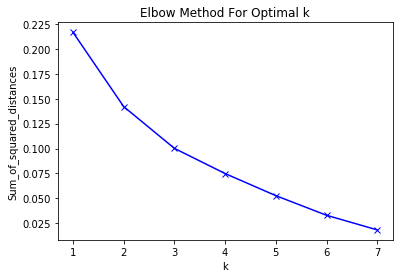

In [31]:
### Use K-Means on a range of K and map the sum of squares (SOS) to find the optimal value of K
K = range(1,8)
Sum_of_squared_distances = []

for kclusters in K:
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vermont_grouped_clustering)
   
    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 

    # add clustering labels
    vermont_venues_sorted.drop(['Clusters'], axis=1, inplace=True)
    vermont_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

    vermont_merged = vtcities
    # merge the dataframes to add latitude/longitude for each City
    vermont_merged = vermont_merged.join(vermont_venues_sorted.set_index('City'), on='City')
    vermont_merged.dropna(inplace=True)
    
    ### Test each K value   
    Sum_of_squared_distances.append(kmeans.inertia_)
    
### Map K so we can choose the optimal value at the elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
### Not the most obvious elbow but K=5 seems like the best choice
### Cluster all the city food and drink data into 5 clusters

k=5
### Run K-Means using the optimal K (elbow)
kmeans = KMeans(n_clusters=k, random_state=0).fit(vermont_grouped_clustering)
   
# add clustering labels
vermont_venues_sorted.drop(['Clusters'], axis=1, inplace=True)
vermont_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

vermont_merged = vtcities
# merge the dataframes to add latitude/longitude for each City
vermont_merged = vermont_merged.join(vermont_venues_sorted.set_index('City'), on='City')
vermont_merged.dropna(inplace=True)
vermont_merged['Clusters'] = vermont_merged.Clusters.astype('int64')
vermont_merged


,City,Population,Latitude,Longitude,PopulationInt,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Burlington,"42,453",44.476298,-73.213547,42453,2,Café,Pizza Place,Breakfast Spot,Bakery,Food Truck,New American Restaurant,Deli / Bodega,Sandwich Place,Italian Restaurant,Bar
1,Essex,"20,901",44.490500,-73.111200,20901,1,Pizza Place,Fast Food Restaurant,Sandwich Place,Bakery,Chinese Restaurant,Deli / Bodega,BBQ Joint,Café,Fried Chicken Joint,Soccer Field
2,South Burlington,"18,773",44.466994,-73.170960,18773,4,American Restaurant,Pizza Place,Rental Car Location,Hotel,Chinese Restaurant,Sandwich Place,Creperie,Diner,Airport,Clothing Store
3,Colchester,"17,309",44.547910,-73.155899,17309,4,Gas Station,Sandwich Place,Pizza Place,American Restaurant,Donut Shop,Bagel Shop,Harbor / Marina,Hotel,Fast Food Restaurant,Sports Bar
7,Milton,"10,761",44.635925,-73.112640,10761,3,Pizza Place,Deli / Bodega,Pharmacy,Sandwich Place,Donut Shop,New American Restaurant,Fast Food Restaurant,Discount Store,Farmers Market,Park
8,Essex Junction,"10,132",44.489086,-73.113503,10132,1,Pizza Place,Bakery,Fast Food Restaurant,Sandwich Place,Chinese Restaurant,Deli / Bodega,BBQ Joint,Bar,Mexican Restaurant,Soccer Field
10,Williston,"9,341",44.437404,-73.068962,9341,4,Pizza Place,American Restaurant,Sandwich Place,Bakery,Furniture / Home Store,Asian Restaurant,Steakhouse,Donut Shop,Mexican Restaurant,Sushi Restaurant
15,Shelburne,"7,677",44.380803,-73.227654,7677,2,Bakery,Food,American Restaurant,Pizza Place,Café,Italian Restaurant,Donut Shop,Burger Joint,Brewery,Breakfast Spot
18,Winooski,"7,203",44.491040,-73.186106,7203,2,Deli / Bodega,Café,Sandwich Place,Donut Shop,Food Truck,Pizza Place,American Restaurant,Vietnamese Restaurant,Diner,Bagel Shop
32,Hinesburg,"4,509",44.329251,-73.111267,4509,0,Sandwich Place,Diner,Southern / Soul Food Restaurant,Gastropub,Chinese Restaurant,Bakery,Construction & Landscaping,Pharmacy,Clothing Store,Bar


In [39]:
# Create a map of the clusters
map_clusters = folium.Map(location=[location.latitude, location.longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(vermont_merged['Latitude'], vermont_merged['Longitude'], vermont_merged['City'], vermont_merged['Clusters']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=30,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

# FINALLY - create a map of the clusters + population + pizza restaurants

In [40]:
# Create a map of clusters + population + pizza restaurants
final_map = folium.Map(location=[location.latitude, location.longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add cities and clusters to the map
markers_colors = []
for lat, lon, city, cluster, pop in zip(vermont_merged['Latitude'], vermont_merged['Longitude'], vermont_merged['City'], vermont_merged['Clusters'], vermont_merged['PopulationInt']):
    label = folium.Popup(str(city) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=pop / 500, 
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(final_map)
       
        
for city, venue, venuelat, venuelng in zip(pizza['City'], pizza['Venue'], pizza['VenueLatitude'], pizza['VenueLongitude']):
    label = '{} - {}'.format(venue, city)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [venuelat, venuelng],
        popup=label,
        icon=folium.Icon(color='black')
        ).add_to(final_map)  
        
final_map

In [41]:
### Given the cluster information - let's review the detailed stats from earlier
vtstats

,City,PizzaCount,Population,Latitude,Longitude,PopulationInt,Area,PopulationPerArea,PopulationPerPizza,PizzaCountAdjusted
0,Burlington,14,"42,453",44.476298,-73.213547,42453,15.49,2740,3032,7000
1,Essex,8,"20,901",44.490500,-73.111200,20901,39.32,531,2612,4000
2,Essex Junction,7,"10,132",44.489086,-73.113503,10132,4.70,2155,1447,3500
3,Williston,6,"9,341",44.437404,-73.068962,9341,30.58,305,1556,3000
4,South Burlington,6,"18,773",44.466994,-73.170960,18773,29.58,634,3128,3000
5,Milton,5,"10,761",44.635925,-73.112640,10761,60.89,176,2152,2500
6,Colchester,4,"17,309",44.547910,-73.155899,17309,58.57,295,4327,2000
7,Winooski,3,"7,203",44.491040,-73.186106,7203,1.51,4770,2401,1500
8,Shelburne,2,"7,677",44.380803,-73.227654,7677,45.07,170,3838,1000
9,Hinesburg,1,"4,509",44.329251,-73.111267,4509,39.83,113,4509,500


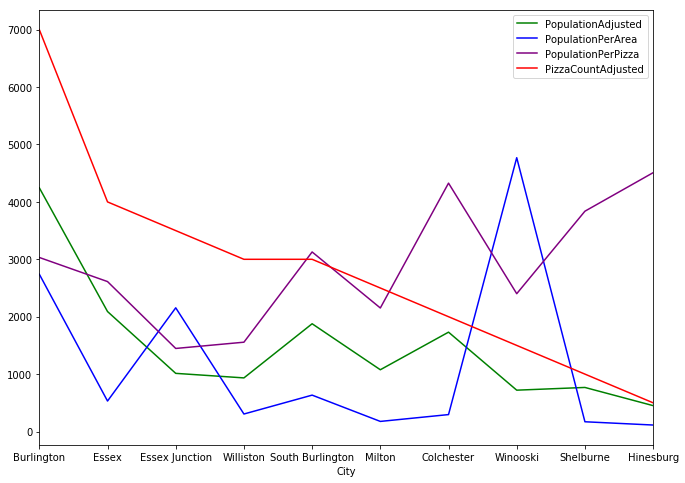

In [47]:
### We are looking primarily for a HIGH PopulationPerPizza and less importantly a HIGH PopulationPerArea (dense population - more foot traffic)

vtstats['PizzaCountAdjusted'] = vtstats['PizzaCount'] * 500
vtstats['PopulationAdjusted'] = vtstats['PopulationInt'] / 10

ax = plt.gca()
vtstats.plot(kind='line',x='City',y='PopulationAdjusted', color='green', ax=ax)
vtstats.plot(kind='line',x='City',y='PopulationPerArea', color='blue', ax=ax)
vtstats.plot(kind='line',x='City',y='PopulationPerPizza', color='purple', ax=ax)
vtstats.plot(kind='line',x='City',y='PizzaCountAdjusted', color='red', ax=ax)

fig = plt.gcf() 
fig.set_size_inches(11,8)
plt.show()

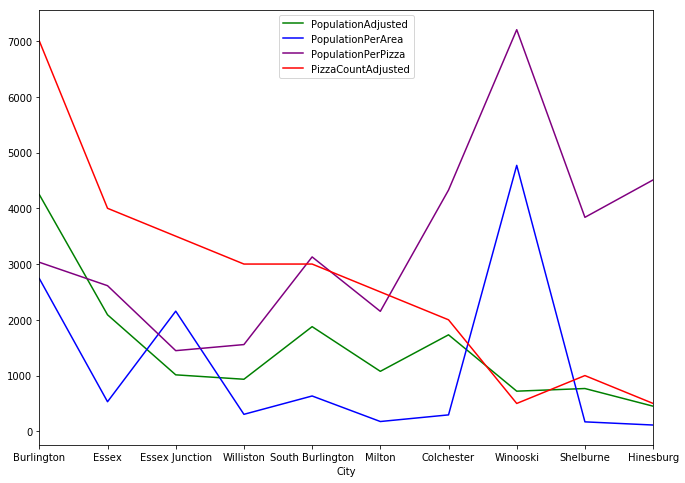

In [61]:
### After some more research there really is only 1 sit-down pizza restaurant still active in Winooski - how would that change the graph?
vtstats.iloc[7, vtstats.columns.get_loc('PizzaCount')] = 1
vtstats.iloc[7, vtstats.columns.get_loc('PizzaCountAdjusted')] = 500
vtstats.iloc[7, vtstats.columns.get_loc('PopulationPerPizza')] = 7203

#vtstats
ax = plt.gca()
vtstats.plot(kind='line',x='City',y='PopulationAdjusted', color='green', ax=ax)
vtstats.plot(kind='line',x='City',y='PopulationPerArea', color='blue', ax=ax)
vtstats.plot(kind='line',x='City',y='PopulationPerPizza', color='purple', ax=ax)
vtstats.plot(kind='line',x='City',y='PizzaCountAdjusted', color='red', ax=ax)

fig = plt.gcf() 
fig.set_size_inches(11,8)
plt.show()

---

## RESULTS AND DISCUSSION <a name="results"></a>

What did we learn in our research about Vermont population and restaurants?
- A large portion of Vermont's population is centered around the Burlington City in Chittenden County(~25% ~160,000 people) 
- This group by cities and towns already contains a large number of pizza restaurants, but given that population numbers are rising here while they decline elsewhere in the state - it seems like a good area to invest
- 57 pizza places exist today in the 10 towns around Burlington, VERMONT
- Burlington is THE big city of Vermont - businesses thrive there, including pizza restaurants with the most in the area(14).   We could open another business in Burlington, but perhaps a better solution is to find a city that is most similar to Burlington
- A couple towns in the area are similar in "most common venues" to Burlington 
  * The similar towns are : Shelburne and Winooski
- The city with the highest PopulationPerArea (population density) is Winooski but since it's only 1.5 square miles - it maybe difficult to find a location
- The city with the highest PopulationPerPizza (# of residents per pizza restaurant) is close between Colchester and Hinesburg
- I did just a few minutes of research into the 3 Winooski pizza restaurants : Domino's Pizza, Pizza Putt, and Pizzeria Ida
  * Pizza Putt is actually closed permanently
  * Domino's Pizza (the well known chain) is delivery only
  * Pizzeria Ida is on the border with Burlington - not in the downtown Winooski area
- Further analysis would want to compare real estate prices, property taxes, and real estate availability in each city/town, as well as more investigation on each existing venue to ensure that they are are still up and running - it seems the FourSquare data might be slightly outdated

---

## CONCLUSION <a name="conclusion"></a>

For anyone who is interested in opening a pizza restaurant in Vermont - they should certainly look to the Burlington area - with 25% of the state poulation and all towns growing consistently.
While they could look for real estate right in Burlington - I suspect it is the most expensive in the area and they would also face the most competition.  I would instead recommend looking at the surrounding towns.

Winooski and Shelburne have the most similar venues to Burlington (per our machine-learning cluster analysis).  Shelburne, however has a low population density while Winooski has the highest in the area.  Winooski also has the highest population per # of pizza restaurants after adjusting for the recently-closed and delivery-only-restaurant.  
So, in conclusion - I would recommend opening a new pizza restaurant in Winooski.

---